## Basic analysis of free walking trials in blue (optogenetics) arena

In [1]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.io import loadmat
from scipy.stats.stats import pearsonr    

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import gridspec
import matplotlib.colors as colors
import seaborn as sns

from os import listdir, mkdir
from glob import glob
from os.path import isfile, sep
from sys import path, exit

# Import custom plotting functions
path.insert(1, '/Users/hannah/Dropbox/code/plottingUtilities/')
from plottingUtilities import myAxisTheme, timeAxisTheme, niceScatterPlot, makeNestedPlotDirectory
from flyTracePlots import plotPosInRange, plotFlyVRtimeStp, plotPolarTrace
from velocityDistributionPlots import plotVeloHistogram_fancy, velocitySummaryPlot
from objectInteractionPlots import radDistAngleCombiPlot_freeWalking, residencyWithHistograms_splitOnWalking,\
                                   curvatureVsHeading_DistanceBoxplot

# Import custom data processing functions
path.insert(1, '/Users/hannah/Dropbox/code/flyFreeWalking/utilities/')
from loadFreeWalkingData import loadCtraxData

path.insert(1, '/Users/hannah/Dropbox/code/trajectoryAnalysis/')
from trajectoryDerivedParams import convertRawHeadingAngle, velocityFromTrajectory, relationToObject,\
                                    computeCurvature
from plotsWithDataframe import plotVeloHeadingDistribution_freeWalk, plotVeloHeadingDistribution2_freeWalk


from Tkinter import Tk
from tkFileDialog import askdirectory, askopenfilename

from datetime import timedelta
from time import strptime

%matplotlib inline 

#from flyVR_oneTrialBasicAnalysis import singleVRTrialAnalysis

sns.set_style('ticks')

#### Choose files to analyse

In [2]:
baseDir = '/Volumes/jayaramanlab/Hannah/Projects/FreeWalkingArena/1_ObjectTracking/blueLight_100x400ConeGlass/'

frameRate = 12.3

root = Tk()
# prevents root window from appearing
root.withdraw()
# choose experiment folder
expDir = askdirectory(initialdir=baseDir, title='Select experiment directory of a single fly') + sep
dataDir = sep.join(expDir.split(sep)[0:-2]) + sep

# create analysis dir
analysisDir = dataDir + 'analysis/'
try:
    mkdir(analysisDir)
except OSError:
    print('Analysis directory already exists.')
        

FWDataFiles = [filepath.split(sep)[-1] for filepath in glob(expDir + '*.mat')]
FWDataFiles = sorted(FWDataFiles)

FWDataFiles = FWDataFiles[0:20]
numFlies = len(FWDataFiles)
print('\n Analysing the following ' + str(numFlies) + ' log files:\n')
print(FWDataFiles)

Analysis directory already exists.

 Analysing the following 20 log files:

['100x400ConeGlass_WTB_m01_7d_cam_0_date_2015_11_18_time_22_24_53_v001.mat', '100x400ConeGlass_WTB_m02_7d_cam_0_date_2015_11_18_time_23_02_06_v001.mat', '100x400ConeGlass_WTB_m03_7d_cam_0_date_2015_11_18_time_23_30_14_v001.mat', '100x400ConeGlass_WTB_m04_7d_cam_0_date_2015_11_18_time_23_46_54_v001.mat', '100x400ConeGlass_WTB_m05_5d_cam_0_date_2015_11_21_time_15_24_35_v001.mat', '100x400ConeGlass_WTB_m06_5d_cam_0_date_2015_11_21_time_15_35_59_v001.mat', '100x400ConeGlass_WTB_m07_5d_cam_0_date_2015_11_21_time_16_13_33_v001.mat', '100x400ConeGlass_WTB_m08_5d_cam_0_date_2015_11_21_time_16_26_52_v001.mat', '100x400ConeGlass_WTB_m09_5d_cam_0_date_2015_11_21_time_16_39_25_v001.mat', '100x400ConeGlass_WTB_m10_5d_cam_0_date_2015_11_21_time_17_13_05_v001.mat', '100x400ConeGlass_WTB_m11_5d_cam_0_date_2015_11_21_time_17_53_13_v001.mat', '100x400ConeGlass_WTB_m12_5d_cam_0_date_2015_11_21_time_18_04_32_v001.mat', '100x400Con

In [3]:
def makePlotDirectory(dirpath):
    try:
        mkdir(dirpath)
    except OSError:
        print('Plot directory already exists.')

In [4]:
def computeVelocities(x,y,angle,t):
    vTrans = np.zeros(len(t))
    vTrans[1:] = np.hypot(np.diff(x),np.diff(y))/np.diff(t)
    vTrans[np.where(np.isnan(vTrans))[0]] = 0 
    
    vRot = np.zeros(len(t))
    vRot[0:-1] = np.diff(angle)
    vRot[vRot > np.pi] -= 2*np.pi
    vRot[vRot <= -np.pi] += 2*np.pi
    vRot[0:-1] = vRot[0:-1] / np.diff(t)
    vRot[np.where(np.isnan(vRot))[0]] = 0
    
    return vTrans, vRot

In [24]:
px2mm = 40/10 # 1000/228 #68/15 #px/mm
arenaRad = 60

try:
    objLocall = np.load(expDir + 'objectLocations.npy')
except IOError:
    objLocall = [[517,510],[517,510],[517,510],[517,510],[517,510],[517,512],[517,512],[517,512],
                 [517,512],[515,510],[515,510],[515,510],[515,512],[515,510],[515,510],[515,510],
                 [512,512],[515,510],[515,507],[515,507]]

    for fly in range(numFlies): 
        objLocall[fly][0] = objLocall[fly][0]/px2mm
        objLocall[fly][1] = objLocall[fly][1]/px2mm

    np.save(expDir + 'objectLocations', objLocall)

Plot directory already exists.


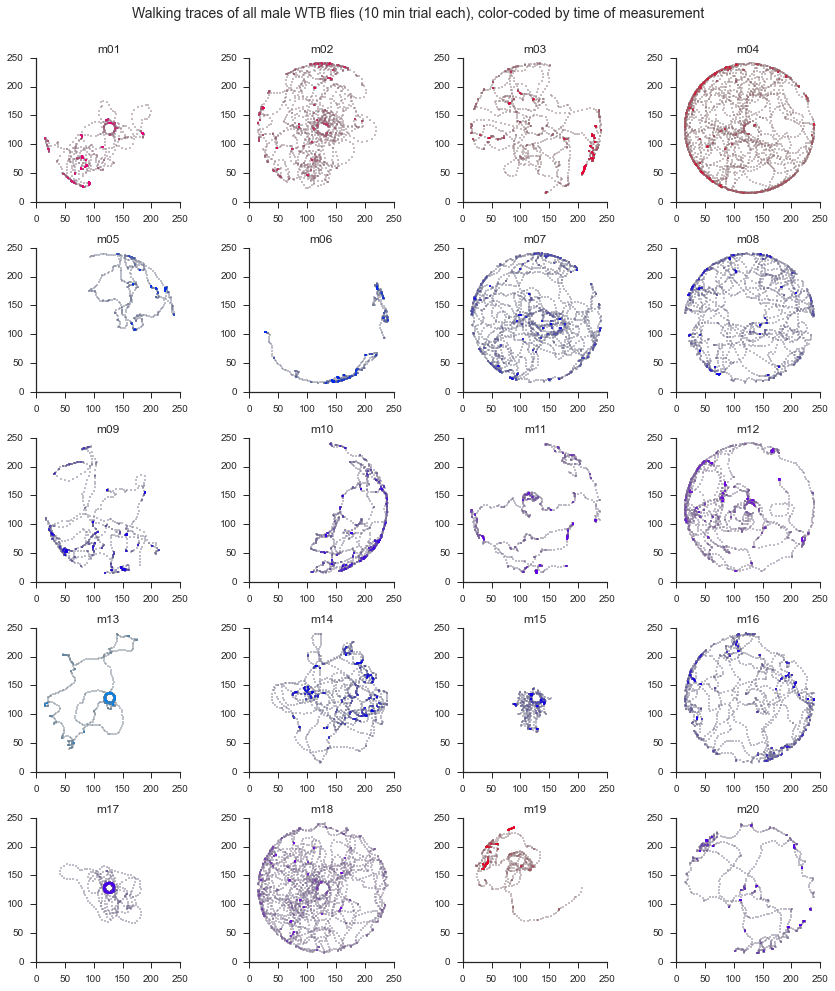

In [25]:
tracePlot = plt.figure(figsize=(12,14))
gs = gridspec.GridSpec(6,4,height_ratios=(0.1,1,1,1,1,1))

timeall = []
xposall = []
yposall = []
angleall = []
objdistall = []
exptime = np.zeros(numFlies)
flyIDs = []

for fly in range(numFlies):
    
    fileToAnalyse = FWDataFiles[fly]
    arena = fileToAnalyse.split('_')[0]
    genotype = fileToAnalyse.split('_')[1]
    flyID = fileToAnalyse.split('_')[2]
    flyIDs.append(flyID)
    
    if 'm' in flyID:
        gender = 'male'
    elif 'f' in flyID:
        gender = 'female' 
    else:
        gender = 'mixed'

    timeOfDay = ':'.join(fileToAnalyse.split('_')[-4:-1])

    timeStr = strptime(timeOfDay,'%H:%M:%S')
    timecolor = timedelta(hours=timeStr.tm_hour,minutes=timeStr.tm_min,seconds=timeStr.tm_sec).total_seconds()
    exptime[fly] = timecolor
    
    #load matlab data and convert
    keyList = ['timestamps','x_pos','y_pos','ntargets','identity','angle']
    indat = loadmat(expDir + fileToAnalyse)
    
    time, xPos, yPos, angle = loadCtraxData(indat,keyList)
    xPos = xPos/px2mm
    yPos = yPos/px2mm
    
    timeall.append(np.asarray(time))
    xposall.append(np.asarray(xPos))
    yposall.append(np.asarray(yPos))
    angleall.append(np.asarray(angle))
    
    objLoc = objLocall[fly]
    objDist = np.hypot(xPos-objLoc[0],yPos-objLoc[1])
    objdistall.append(np.asarray(objDist))
    
    cNorm  = colors.Normalize(vmin=0, vmax=60*60*24)
    scalarMap = plt.cm.ScalarMappable(norm=cNorm,cmap='hsv')
    
    selectPts = range(0,len(time),2)
    sbplt = tracePlot.add_subplot(gs[fly+4])
    sbplt.plot(xPos[selectPts],yPos[selectPts],'.',markersize=3,color = 'grey')
    sbplt.plot(xPos[selectPts],yPos[selectPts],'.',markersize=3,color = scalarMap.to_rgba(timecolor), alpha = 0.1)
    
    sbplt.set_title(flyID)
    myAxisTheme(sbplt)
    sbplt.set_aspect('equal')
    sbplt.set_xlim(0, 250)
    sbplt.set_ylim(0, 250)

makePlotDirectory(analysisDir + 'tracePlot' + sep)
tracePlot.tight_layout()
tracePlot.suptitle('Walking traces of all ' + gender + ' ' + genotype + ' flies (10 min trial each), color-coded by time of measurement',
                   fontsize = 14, y=0.98)

tracePlot.savefig(analysisDir + 'tracePlot' + sep + genotype + '_' + gender 
                  + '_traceExpTimeColored_n' + str(numFlies) + '.pdf', format='pdf')

In [26]:
# generate fly color map
cNorm  = colors.Normalize(vmin=0, vmax=len(FWDataFiles))
flyCMap = plt.cm.ScalarMappable(norm=cNorm,cmap='Accent')

# set some parameter
arenaRad = 60
vTransTH = 2

Plot directory already exists.
Plot directory already exists.


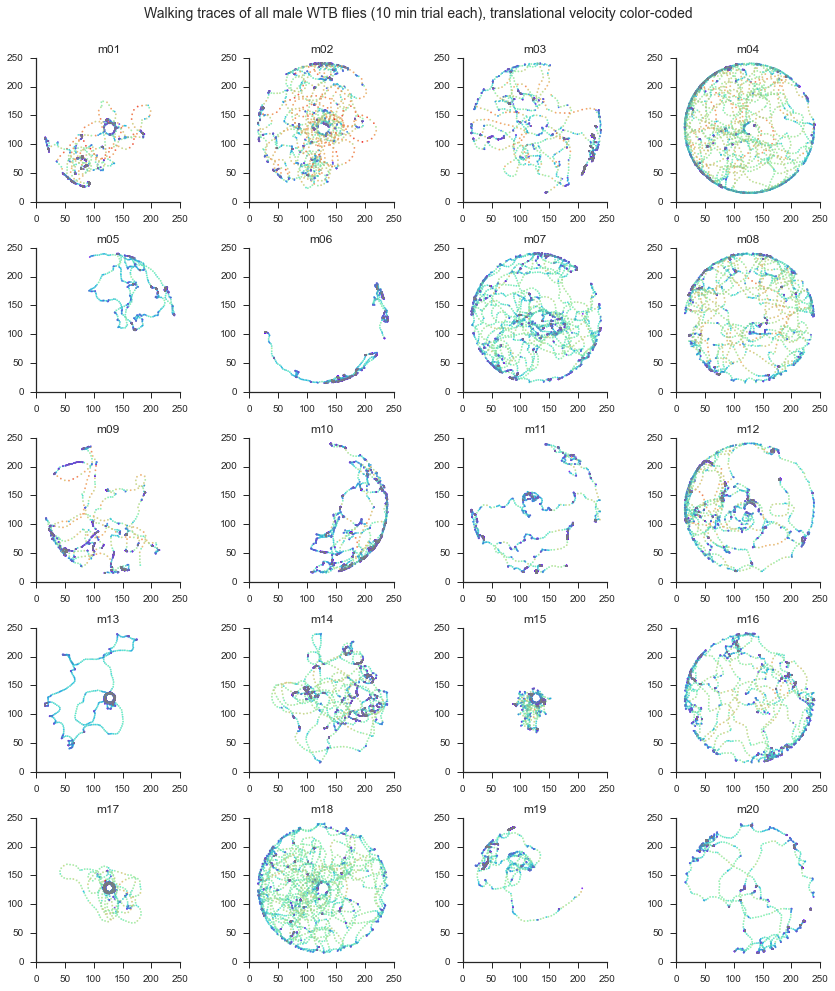

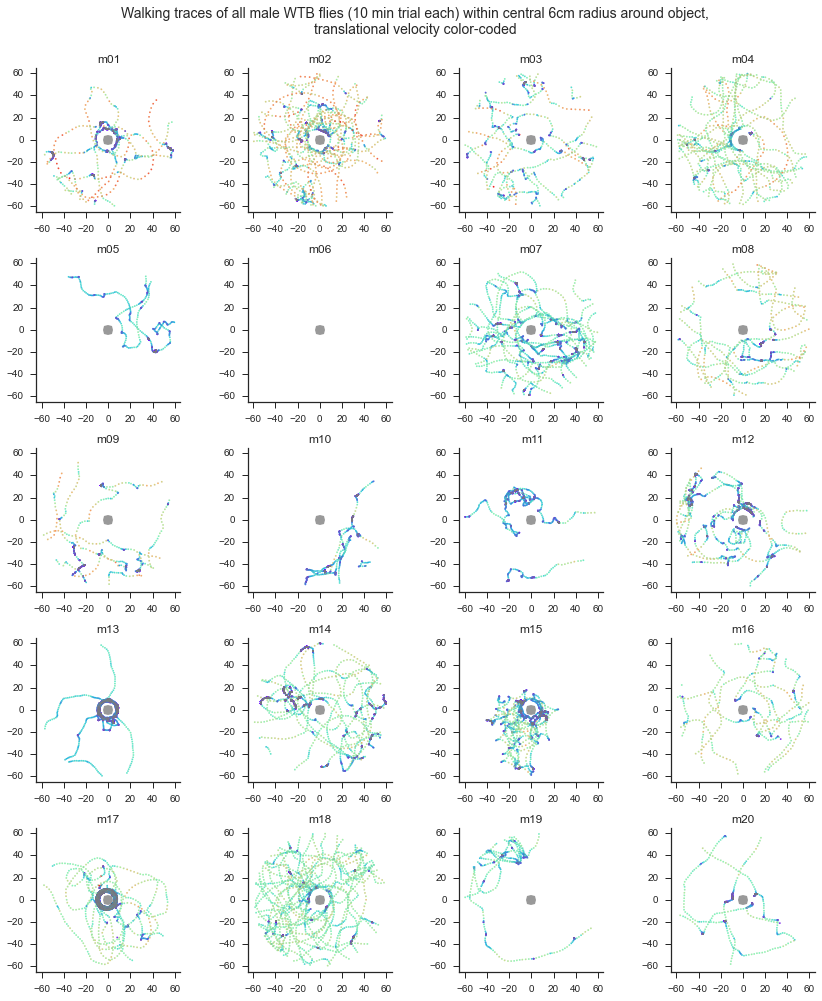

In [27]:
timeallarray = []
xposallarray = []
yposallarray = []
angleallarray = []
vrotallarray = []
vtransallarray = []
objdistallarray = []
flyIDallarray = []
objLocallarrayX = []
objLocallarrayY = []

tracePlot = plt.figure(figsize=(12,14))
tracePlotMA = plt.figure(figsize=(12,14))
gs = gridspec.GridSpec(6,4, height_ratios=(0.1,1,1,1,1,1))

veloDistr = plt.figure(figsize=(14,5))
numBins = 40

for fly in range(numFlies):
    flyIDallarray = np.hstack((flyIDallarray,fly*np.ones(len(timeall[fly])))) 
    timeallarray = np.hstack((timeallarray,timeall[fly]))
    xposallarray = np.hstack((xposallarray,xposall[fly]))
    yposallarray = np.hstack((yposallarray,yposall[fly]))
    angleallarray = np.hstack((angleallarray,angleall[fly]))
    objdistallarray = np.hstack((objdistallarray,objdistall[fly]))
    objLocallarrayX = np.hstack((objLocallarrayX,objLocall[fly][0]*np.ones(len(timeall[fly])))) 
    objLocallarrayY = np.hstack((objLocallarrayY,objLocall[fly][1]*np.ones(len(timeall[fly])))) 
    
    objLoc = objLocall[fly]
    
    vTransfly, vRotfly = computeVelocities(xposall[fly],yposall[fly],angleall[fly],timeall[fly])
    vrotallarray = np.hstack((vrotallarray, vRotfly))
    vtransallarray = np.hstack((vtransallarray, vTransfly))
    
    selectPts = range(0,len(yposall[fly]),2)
    sbplt = tracePlot.add_subplot(gs[fly+4])
    sbplt.plot(xposall[fly][selectPts],yposall[fly][selectPts],'.', markersize=3, 
               color='grey', alpha=0.2)
    sbplt.scatter(xposall[fly][selectPts],yposall[fly][selectPts], s=3, 
                  c=vTransfly[selectPts], cmap='rainbow', alpha = 0.9, edgecolor='none',
                  vmin=-1, vmax=60)
    
    sbplt.set_title(flyIDs[fly])
    myAxisTheme(sbplt)
    sbplt.set_xlim(0, 250)
    sbplt.set_ylim(0, 250)
    sbplt.set_aspect('equal')
    
    sbplt = tracePlotMA.add_subplot(gs[fly+4])
    sbplt.plot(xposall[fly][objdistall[fly]<arenaRad]-objLoc[0],yposall[fly][objdistall[fly]<arenaRad]-objLoc[1],
               '.', markersize=3, color='grey', alpha=0.2)
    sbplt.scatter(xposall[fly][objdistall[fly]<arenaRad]-objLoc[0],yposall[fly][objdistall[fly]<arenaRad]-objLoc[1],
                  s=3, c=vTransfly[objdistall[fly]<arenaRad], cmap='rainbow', alpha = 0.9, 
                  vmin=-1, vmax=60, edgecolor='none')
    sbplt.plot(0,0,'o',markersize=10, color='black', alpha=0.4)
    sbplt.set_title(flyIDs[fly])
    sbplt.set_xlim(-(arenaRad+5),arenaRad+5)
    sbplt.set_ylim(-(arenaRad+5),arenaRad+5)
    myAxisTheme(sbplt)
    sbplt.set_aspect('equal')
    
tracePlot.tight_layout()
tracePlot.suptitle('Walking traces of all ' + gender + ' ' + genotype + ' flies (10 min trial each), translational velocity color-coded',
                   fontsize = 14, y=0.98)
tracePlotMA.tight_layout()
tracePlotMA.suptitle('Walking traces of all ' + gender + ' ' +  genotype + ' flies (10 min trial each) within central 6cm radius around object,\ntranslational velocity color-coded',
                   fontsize = 14, y=0.99)

makePlotDirectory(analysisDir + 'tracePlot' + sep)
tracePlot.savefig(analysisDir +  'tracePlot' + sep + genotype + '_' + gender 
                  + '_traceVeloColored_n' + str(numFlies) + '.pdf', format='pdf')

makePlotDirectory(analysisDir + 'tracePlotMA' + sep)
tracePlotMA.savefig(analysisDir +  'tracePlotMA' + sep + genotype + '_' + gender 
                  + '_miniArenaTraceVeloColored_n' + str(numFlies) + '.pdf', format='pdf')

In [28]:
flyIDNameallarray = []
for fly in range(numFlies):
    for t in range(len(timeall[fly])):
        flyIDNameallarray.append(flyID[0][0]+str(fly+1).zfill(2))    
flyIDNameallarray = np.asarray(flyIDNameallarray)

In [17]:
vTransall, vRotall = computeVelocities(xposallarray,yposallarray,angleallarray,timeallarray)
movingall = vTransall >= vTransTH

objDirectall, objDistall, gammaFullall, gammaall, gammaVall = \
        relationToObject(timeallarray, xposallarray, yposallarray, angleallarray, objLoc)

d_objDistall = np.hstack((0, np.diff(np.convolve(objDistall, np.ones((7,))/7, mode='same'))))

Plot directory already exists.


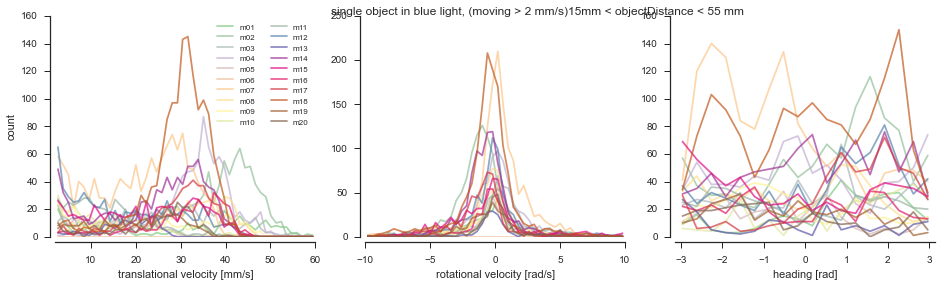

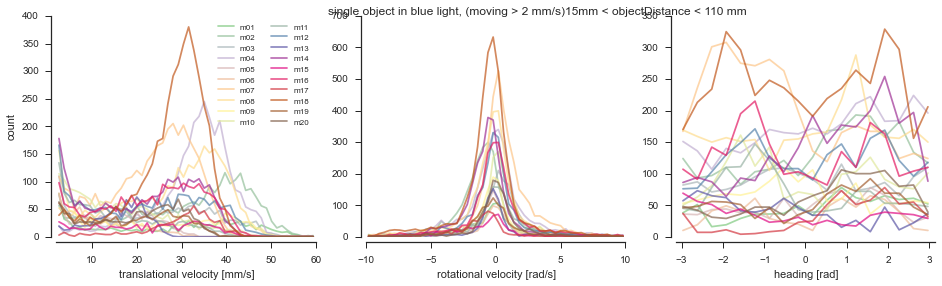

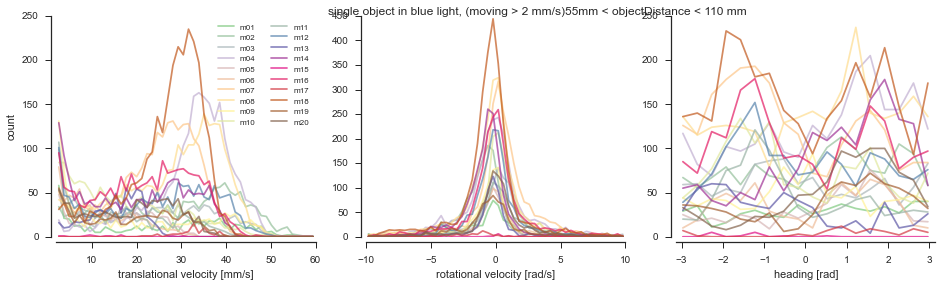

In [18]:
makePlotDirectory(analysisDir + 'velocityTraces' + sep)   

veloDistFig = plotVeloHeadingDistribution2_freeWalk(flyIDs, vTransTH, vtransallarray, vrotallarray,
                                                    objdistallarray, gammaFullall, flyIDNameallarray,15,55)
veloDistFig.tight_layout()
veloDistFig.savefig(analysisDir + 'velocityTraces/'  + genotype + '_' + gender
                        + '_veloDistributions2_15-55mm_n'+ str(len(flyIDs)) + '.pdf', format='pdf')

veloDistFig = plotVeloHeadingDistribution2_freeWalk(flyIDs, vTransTH, vtransallarray, vrotallarray,
                                                    objdistallarray, gammaFullall, flyIDNameallarray,15,110)
veloDistFig.tight_layout()
veloDistFig.savefig(analysisDir + 'velocityTraces/'  + genotype + '_' + gender
                        + '_veloDistributions2_15-110mm_n'+ str(len(flyIDs)) + '.pdf', format='pdf')

veloDistFig = plotVeloHeadingDistribution2_freeWalk(flyIDs, vTransTH, vtransallarray, vrotallarray,
                                                    objdistallarray, gammaFullall, flyIDNameallarray,55,110)
veloDistFig.tight_layout()
veloDistFig.savefig(analysisDir + 'velocityTraces/'  + genotype + '_' + gender
                        + '_veloDistributions2_55-110mm_n'+ str(len(flyIDs)) + '.pdf', format='pdf')

In [59]:
def plotVeloHeadingDistribution_freeWalk(flyIDs, vTransTH, vTransAll, vRotAll, objDistAll, gammaFullAll, flyIDAll,\
                                         minDist, maxDist):
    """ Plot velocity and relative heading distributions (non-normalised) for a set of flies """

    numFlies = len(flyIDs)
    flyCMap = plt.cm.ScalarMappable(norm=colors.Normalize(vmin=0, vmax=numFlies), cmap='Accent')

    vRotRange = (-10, 10)
    angleRange = (-np.pi, np.pi)

    veloDistFig = plt.figure(figsize=(15, 4))

    gs = gridspec.GridSpec(1, 4, width_ratios=(4, 4, 4, 1.25))

    vTsubplt = veloDistFig.add_subplot(gs[0])
    vTsubplt.set_xlabel('translational velocity [mm/s]')
    vTsubplt.set_ylabel('count')
    sns.despine(right=True, offset=5, trim=False)
    sns.axes_style({'axes.linewidth': 1, 'axes.edgecolor': '.8'})

    vRsubplt = veloDistFig.add_subplot(gs[1])
    vRsubplt.set_xlabel('rotational velocity [rad/s]')
    sns.despine(right=True, offset=5, trim=False)
    sns.axes_style({'axes.linewidth': 1, 'axes.edgecolor': '.8'})

    hsubplt = veloDistFig.add_subplot(gs[2])
    hsubplt.set_xlabel('heading [rad]')
    sns.despine(right=True, offset=5, trim=False)
    sns.axes_style({'axes.linewidth': 1, 'axes.edgecolor': '.8'})

    nhAll = np.zeros((18, numFlies))
    meanSpeeds = np.zeros(numFlies)

    flyIDsShort = []
    [flyIDsShort.append(flyIDs[fly][-3:]) for fly in range(numFlies)]

    selectMove = vTransAll > vTransTH
    selectDist = np.logical_and(objDistAll>minDist,objDistAll<maxDist)
    select = np.logical_and(selectMove,selectDist)

    for flyInd, flyID in enumerate(flyIDs):
        selectFly = np.logical_and(select,flyIDAll == flyIDs[flyInd])
        tV = vTransAll[selectFly]
        rV = vRotAll[selectFly]
        # v trans
        ntV, binEdges=np.histogram(tV, bins=50, range=(vTransTH, 60))
        bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
        vTsubplt.plot(bincenters, ntV, alpha=0.7, color=flyCMap.to_rgba(flyInd))

        # v rot
        nrV, binEdges = np.histogram(rV, bins=50, range=vRotRange)
        bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
        vRsubplt.plot(bincenters, nrV, alpha=0.7, color=flyCMap.to_rgba(flyInd))

        # heading
        h = gammaFullAll[selectFly]
        nh, binEdges = np.histogram(h, bins=18, range=angleRange)
        bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
        nh, binEdges = np.histogram(h, bins=18, range=(0, np.pi))
        if np.nansum(ntV) > 10*60*12.3*0.05:
            nhAll[:, flyInd] = nh
            meanSpeeds[flyInd] = np.mean(tV)

    X, Y = np.meshgrid(range(0, numFlies+1), binEdges)
    sortedSpeeds = [i[0] for i in sorted(enumerate(meanSpeeds), key=lambda x:x[1])]
    nhAll_sorted = nhAll[:, sortedSpeeds]
    toPlot = nhAll_sorted/np.transpose(np.sum(nhAll_sorted,0))
    toPlot[np.isnan(toPlot)] = 0
    hsubplt.pcolormesh(Y, X, toPlot, cmap='Greys')
    hsubplt.set_title(str(minDist) + 'mm < objectDistance < ' + str(maxDist) + ' mm ')
    hsubplt.yaxis.set_visible(False)
    for fly in range(numFlies):
        hsubplt.text(np.pi+0.1, sortedSpeeds[fly]+.5, flyIDsShort[fly], fontsize=12)

    vTsubplt.set_xlim((vTransTH, 60))
    vRsubplt.set_xlim(vRotRange)
    hsubplt.set_xlim((0, np.pi))

    veloDistFig.suptitle('single object in blue light, (moving > '+str(vTransTH)+' mm/s)'+
                         str(minDist) + 'mm < objectDistance < '+str(maxDist)+' mm', fontsize=12)
    vTsubplt.legend(flyIDs, ncol=2, loc=1, fontsize=8)

    return veloDistFig, nhAll_sorted


Plot directory already exists.


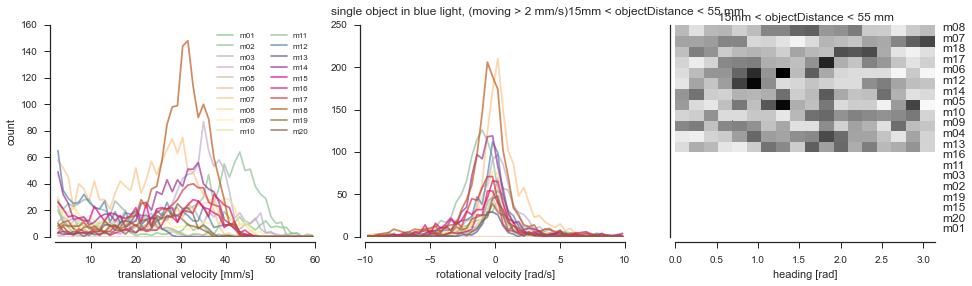

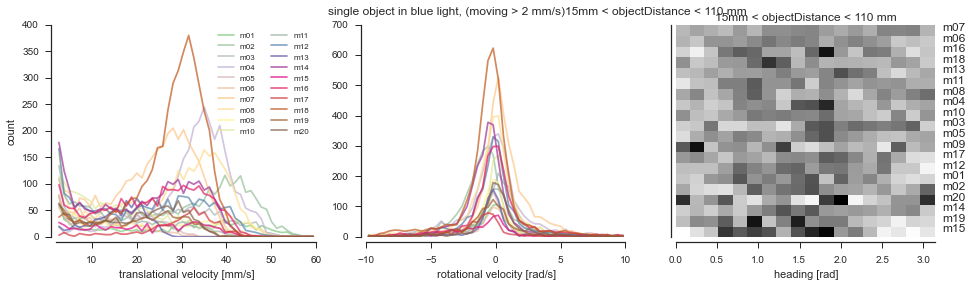

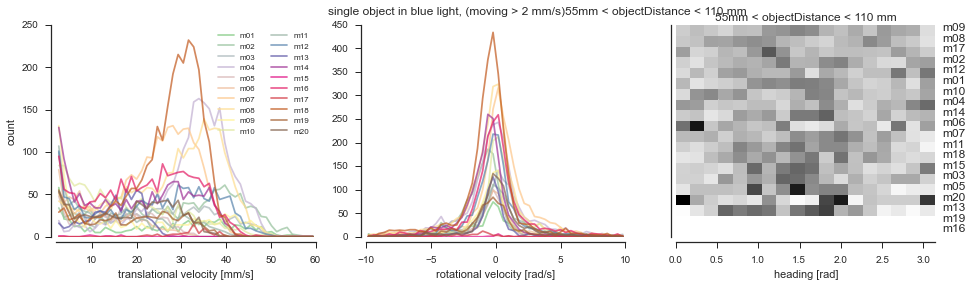

In [60]:
makePlotDirectory(analysisDir + 'velocityTraces' + sep)   

veloDistFig,nhAll_sorted = plotVeloHeadingDistribution_freeWalk(flyIDs, vTransTH, vtransallarray, vrotallarray,
                                                    objdistallarray, gammaFullall, flyIDNameallarray,15,55)
veloDistFig.tight_layout()
veloDistFig.savefig(analysisDir + 'velocityTraces/'  + genotype + '_' + gender
                        + '_veloDistributions_15-55mm_n'+ str(len(flyIDs)) + '.pdf', format='pdf')

veloDistFig,nhAll_sorted = plotVeloHeadingDistribution_freeWalk(flyIDs, vTransTH, vtransallarray, vrotallarray,
                                                    objdistallarray, gammaFullall, flyIDNameallarray,15,110)
veloDistFig.tight_layout()
veloDistFig.savefig(analysisDir + 'velocityTraces/'  + genotype + '_' + gender
                        + '_veloDistributions_15-110mm_n'+ str(len(flyIDs)) + '.pdf', format='pdf')

veloDistFig,nhAll_sorted = plotVeloHeadingDistribution_freeWalk(flyIDs, vTransTH, vtransallarray, vrotallarray,
                                                    objdistallarray, gammaFullall, flyIDNameallarray,55,110)
veloDistFig.tight_layout()
veloDistFig.savefig(analysisDir + 'velocityTraces/'  + genotype + '_' + gender
                        + '_veloDistributions_55-110mm_n'+ str(len(flyIDs)) + '.pdf', format='pdf')

Plot directory already exists.
Plot directory already exists.
Plot directory already exists.


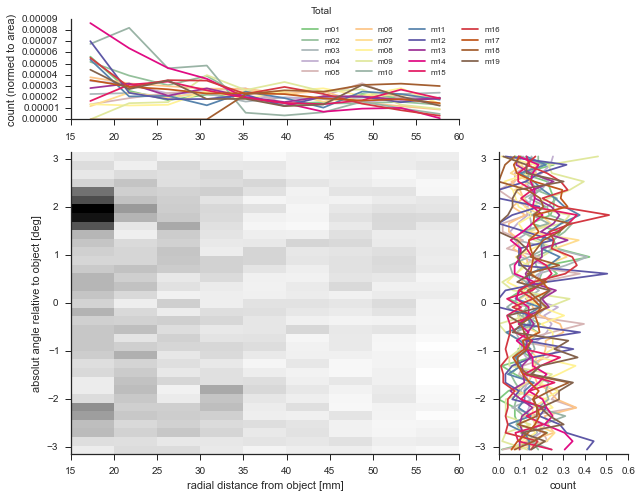

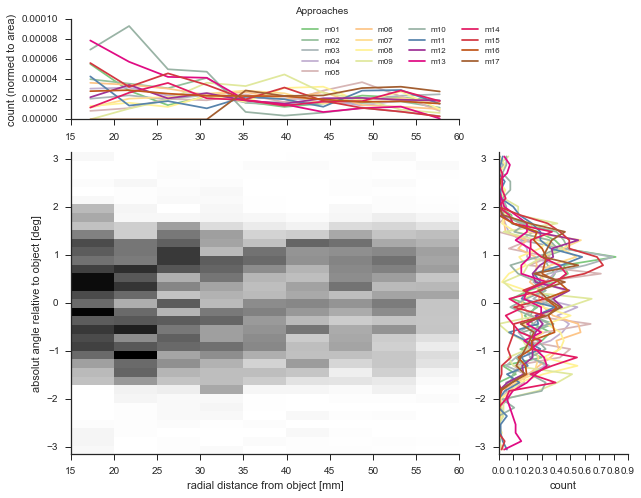

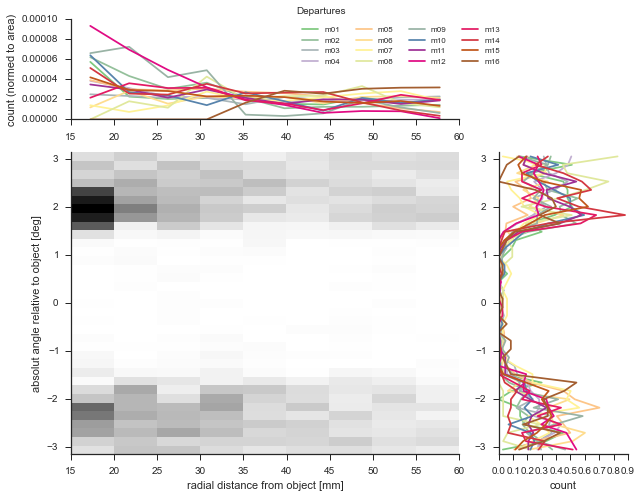

In [63]:
# plot parameter
distBins = 10
angleBins = 36
maxDist = arenaRad
minDist = 15

selectApr = np.logical_and(movingall,d_objDistall<0)
selectDep = np.logical_and(movingall,d_objDistall>0)

headingDistFig = radDistAngleCombiPlot_freeWalking(distBins,angleBins,minDist,maxDist,flyIDs,flyIDNameallarray[movingall],
                                       objDistall[movingall],gammaFullall[movingall])
headingDistFig.suptitle('Total')
makePlotDirectory(analysisDir + 'headingVsDistance' + sep)   
headingDistFig.savefig(analysisDir + 'headingVsDistance' + sep + genotype + '_' + gender 
                  + '_headingVsDistance_n' + str(numFlies) + '.pdf', format='pdf')

headingDistFig = radDistAngleCombiPlot_freeWalking(distBins,angleBins,minDist,maxDist,flyIDs,flyIDNameallarray[selectApr],
                                       objDistall[selectApr],gammaFullall[selectApr])
headingDistFig.suptitle('Approaches')
makePlotDirectory(analysisDir + 'headingVsDistance' + sep)   
headingDistFig.savefig(analysisDir + 'headingVsDistance' + sep + genotype + '_' + gender 
                  + '_headingVsDistance_Apr_n' + str(numFlies) + '.pdf', format='pdf')

headingDistFig = radDistAngleCombiPlot_freeWalking(distBins,angleBins,minDist,maxDist,flyIDs,flyIDNameallarray[selectDep],
                                       objDistall[selectDep],gammaFullall[selectDep])
headingDistFig.suptitle('Departures')
makePlotDirectory(analysisDir + 'headingVsDistance' + sep)   
headingDistFig.savefig(analysisDir + 'headingVsDistance' + sep + genotype + '_' + gender 
                  + '_headingVsDistance_Dep_n' + str(numFlies) + '.pdf', format='pdf')

In [15]:
def getTurnCounts(selectpts, allturns, leftturns, rightturns, objDist, nBins, histDRange):
    pts_turn = np.logical_and(selectpts, allturns)
    pts_turnR = np.logical_and(selectpts, rightturns)
    pts_turnL = np.logical_and(selectpts, leftturns)

    nTL, _ = np.histogram(objDist[pts_turnL], bins=nBins, range=histDRange)
    nTR, _ = np.histogram(objDist[pts_turnR], bins=nBins, range=histDRange)
    nT, _ = np.histogram(objDist[pts_turn], bins=nBins, range=histDRange)
    nDt, edges = np.histogram(objDist[selectpts], bins=nBins, range=histDRange)

    return nTL, nTR, nT, nDt, edges


def getTurnHistCounts(rotMeas, objDist, tTH, tTH_neg, tTH_pos, nBins, histDRange):
    d_objDist = np.hstack((0, np.diff(objDist)))
    pts_apr = d_objDist < 0
    pts_dep = d_objDist > 0

    # approach
    nTL_apr, nTR_apr, nT_apr, nDt_apr, edges = \
        getTurnCounts(pts_apr, abs(rotMeas) > tTH, rotMeas > tTH_pos, rotMeas < tTH_neg, objDist, nBins, histDRange)
    # departure
    nTL_dep, nTR_dep, nT_dep, nDt_dep, edges = \
        getTurnCounts(pts_dep, abs(rotMeas) > tTH, rotMeas > tTH_pos, rotMeas < tTH_neg, objDist, nBins, histDRange)

    return nTL_apr, nTL_dep, nTR_apr, nTR_dep, nT_apr, nT_dep, nDt_apr, nDt_dep, edges


def getTurnChangeHistCounts(rotMeasure, objDist, turnTH, turnTH_neg, turnTH_pos, numBins, histDRange, change):

    d_objDist = np.hstack((0, np.diff(objDist)))
    pts_apr = d_objDist < 0
    pts_dep = d_objDist > 0

    turns = (abs(rotMeasure) > turnTH).astype('int')
    tst = np.zeros(len(turns))
    tst[1:] = np.diff(turns) == change

    turnsL = (rotMeasure > turnTH_pos).astype('int')
    tstL = np.zeros(len(turnsL))
    tstL[1:] = np.diff(turnsL) == change

    turnsR = (rotMeasure < turnTH_neg).astype('int')
    tstR = np.zeros(len(turnsR))
    tstR[1:] = np.diff(turnsR) == change

    # approach
    nTL_apr, nTR_apr, nT_apr, nDt_apr, edges = getTurnCounts(pts_apr, tst, tstL, tstR, objDist, numBins, histDRange)
    # departure
    nTL_dep, nTR_dep, nT_dep, nDt_dep, edges = getTurnCounts(pts_dep, tst, tstL, tstR, objDist, numBins, histDRange)

    return nTL_apr, nTL_dep, nTR_apr, nTR_dep, nT_apr, nT_dep, nDt_apr, nDt_dep, edges

In [16]:
def turnRatePerDistance_freeWalking(Fig,inAreaMoving, vRotall, xposall, yposall, vTransall, objDistall,
                                    useTurnIndex, useTurnChange, ylimrange, minDist, maxDist, numBins, cMapApr, cMapDep):
    # Find turnTH over all flies
    vRot = vRotall[inAreaMoving]
    xPos_filt = xposall[inAreaMoving]
    yPos_filt = yposall[inAreaMoving]
    objDist = objDistall[inAreaMoving]
    
    #objDist, theta = cartesian2polar(xPos_filt, yPos_filt)

    if useTurnIndex:
        vtrans = vTransall[inAreaMoving]
        vRot_filt = np.convolve(vRot/vtrans, np.ones((5,))/5, mode='same')
        vRot_filt[np.isinf(abs(vRot_filt))] = 0.0
    else:
        vRot_filt = np.convolve(vRot, np.ones((5,))/5, mode='same')

    turnTH_pos = 3*np.nanstd(vRot_filt[vRot_filt >= 0])
    turnTH_neg = -3*np.nanstd(vRot_filt[vRot_filt <= 0])
    turnTH = 3*np.nanstd(abs(vRot_filt))

    axApr = Fig.add_subplot(121)
    axApr.set_title('Approaches', fontsize=12)
    axDep = Fig.add_subplot(122)
    axDep.set_title('Departures', fontsize=12)

    legendtext = []

    if useTurnIndex:
        vRotFly_filt = np.convolve(vRot/vtrans, np.ones((5,))/5, mode='same')
    else:
        vRotFly_filt = np.convolve(vRot, np.ones((5,))/5, mode='same')

    # Get counts
    if useTurnChange:
        nTL_apr, nTL_dep, nTR_apr, nTR_dep, nT_apr, nT_dep, nDt_apr, nDt_dep, edges\
            = getTurnChangeHistCounts(vRotFly_filt, objDist, turnTH, turnTH_neg, turnTH_pos,
                                      numBins, (minDist, maxDist), useTurnChange)
    else:
        nTL_apr, nTL_dep, nTR_apr, nTR_dep, nT_apr, nT_dep, nDt_apr, nDt_dep, edges\
            = getTurnHistCounts(vRotFly_filt, objDist, turnTH, turnTH_neg, turnTH_pos,
                                numBins, (minDist, maxDist))

    binctrs = edges[:-1]+np.mean(np.diff(edges))/2.0

    axApr.plot(binctrs, 1.0*nT_apr/nDt_apr, color=cMapApr)
    axDep.plot(binctrs, 1.0*nT_dep/nDt_dep, color=cMapDep)

    axApr.set_ylabel('normalised turn count')

    for ax in [axApr, axDep]:
        ax.set_xlabel('object distance [mm]')
        ax.set_ylim(ylimrange)
        ax.set_xlim(minDist, maxDist)
        myAxisTheme(ax)

    Fig.tight_layout()

    return Fig

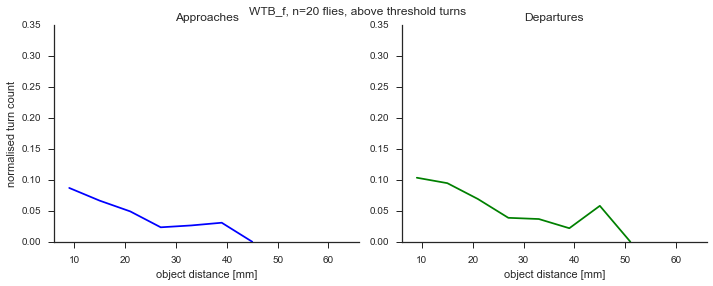

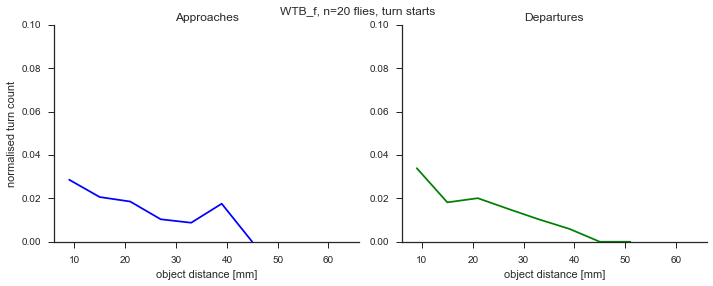

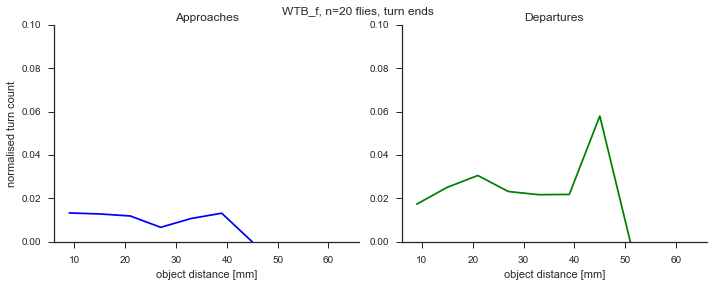

In [17]:
numBins = 10
useTurnIndex = False
minDist = 6
maxDist = 66

vTransTH = 5
movingallarray = vtransallarray >= vTransTH
inAreaMoving = np.logical_and(np.logical_and(objdistallarray>minDist,objdistallarray<maxDist),movingallarray)

useTurnChange = 0

Fig = plt.figure(figsize=(10,4))
Fig.suptitle(genotype +'_'+flyIDs[0][0]+', n='+str(numFlies)+' flies, above threshold turns', fontsize=12)
yLimRange = (0,0.35)
Fig = turnRatePerDistance_freeWalking(Fig,inAreaMoving, vrotallarray, xposallarray, yposallarray, objdistallarray, 
                                      vtransallarray, useTurnIndex, useTurnChange, yLimRange, minDist, maxDist, 
                                      numBins, 'blue', 'green')

useTurnChange = 1

Fig = plt.figure(figsize=(10,4))
Fig.suptitle(genotype +'_'+flyIDs[0][0]+', n='+str(numFlies)+' flies, turn starts', fontsize=12)
yLimRange = (0,0.1)
Fig = turnRatePerDistance_freeWalking(Fig,inAreaMoving, vrotallarray, xposallarray, yposallarray, objdistallarray, 
                                      vtransallarray, useTurnIndex, useTurnChange, yLimRange, minDist, maxDist,
                                      numBins, 'blue', 'green')
useTurnChange = -1

Fig = plt.figure(figsize=(10,4))
Fig.suptitle(genotype +'_'+flyIDs[0][0]+', n='+str(numFlies)+' flies, turn ends', fontsize=12)
yLimRange = (0,0.1)
Fig = turnRatePerDistance_freeWalking(Fig,inAreaMoving, vrotallarray, xposallarray, yposallarray, objdistallarray,
                                      vtransallarray, useTurnIndex, useTurnChange, yLimRange, minDist, maxDist,
                                      numBins, 'blue', 'green')

Plot directory already exists.


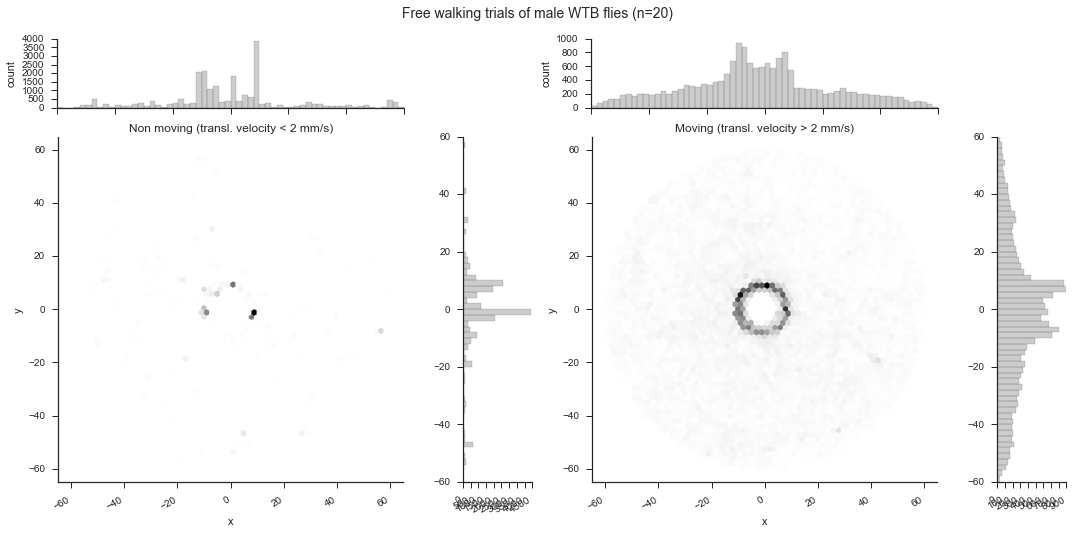

In [64]:
# make fly summary plot of residency:
numBins = 60
arenaRad = 60

selectpts = np.logical_and(objdistallarray<arenaRad,objdistallarray>1)

hexplotfigVI = residencyWithHistograms_splitOnWalking(
    xposallarray[selectpts]-objLocallarrayX[selectpts],
    yposallarray[selectpts]-objLocallarrayY[selectpts],
    movingall[selectpts], arenaRad, numBins, vTransTH,
    'Free walking trials of ' + gender + ' ' + genotype + ' flies (n=' + str(numFlies) + ')')

makePlotDirectory(analysisDir + 'residencyPlots' + sep)   
hexplotfigVI.savefig(analysisDir + 'residencyPlots' + sep + genotype + '_' + gender 
                  + '_miniArenaResidencyPlot_n' + str(numFlies) + '.pdf', format='pdf')

Plot directory already exists.


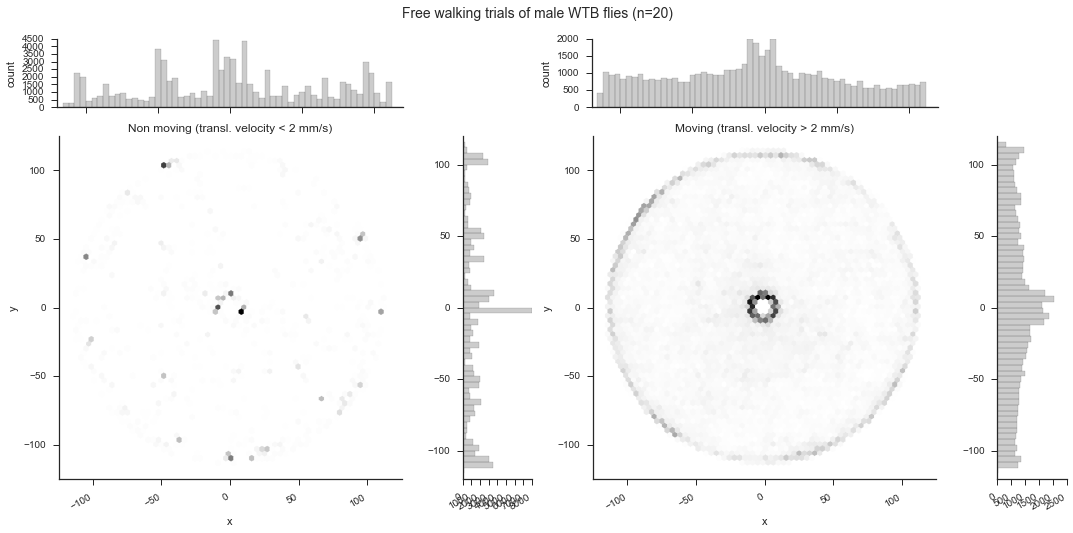

In [65]:
# make fly summary plot of residency:
numBins = 60
arenaRad = 60+60
selectpts = np.logical_and(objdistallarray<arenaRad,objdistallarray>1)

hexplotfigVI = residencyWithHistograms_splitOnWalking(
    xposallarray[selectpts]-objLocallarrayX[selectpts],
    yposallarray[selectpts]-objLocallarrayY[selectpts],
    movingall[selectpts], arenaRad, 
    numBins, vTransTH,'Free walking trials of ' + gender + ' ' + genotype + ' flies (n=' + str(numFlies) + ')')

makePlotDirectory(analysisDir + 'residencyPlots' + sep)   
hexplotfigVI.savefig(analysisDir + 'residencyPlots' + sep + genotype + '_' + gender 
                  + '_fullArenaResidencyPlot_n' + str(numFlies) + '.pdf', format='pdf')

Plot directory already exists.


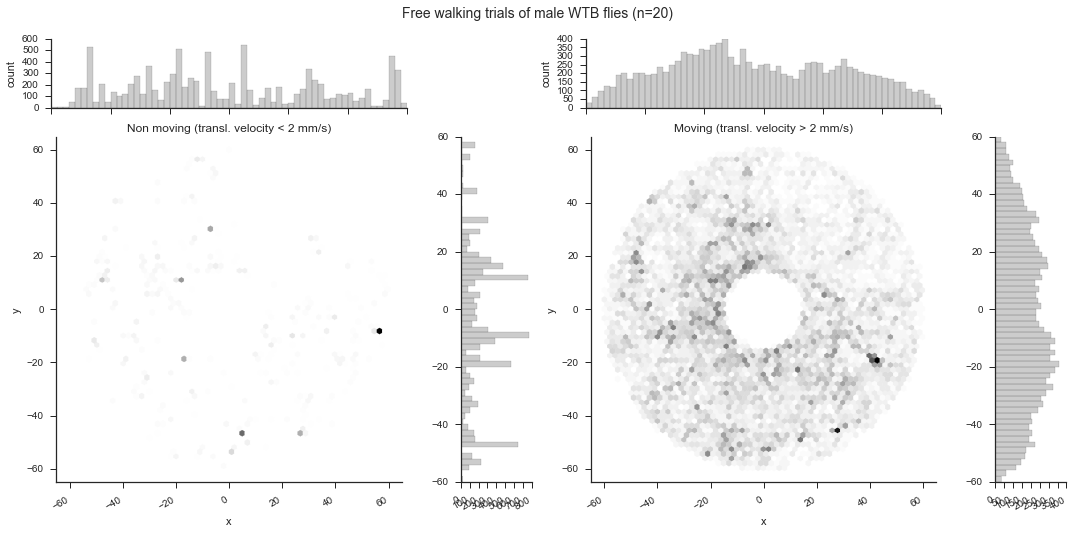

In [69]:
# make fly summary plot of residency:
numBins = 60
arenaRad = 60
selectpts = np.logical_and(objdistallarray<arenaRad,objdistallarray>15)

hexplotfigVI = residencyWithHistograms_splitOnWalking(
    xposallarray[selectpts]-objLocallarrayX[selectpts],
    yposallarray[selectpts]-objLocallarrayY[selectpts],
    movingall[selectpts], arenaRad, 
    numBins, vTransTH,'Free walking trials of ' + gender + ' ' + genotype + ' flies (n=' + str(numFlies) + ')')

makePlotDirectory(analysisDir + 'residencyPlots' + sep)   
hexplotfigVI.savefig(analysisDir + 'residencyPlots' + sep + genotype + '_' + gender 
                  + '_ringArenaResidencyPlot_n' + str(numFlies) + '.pdf', format='pdf')

(0.24899779118893528, 0.28976386675646487)
[[ 1.          0.24899779]
 [ 0.24899779  1.        ]]
Plot directory already exists.


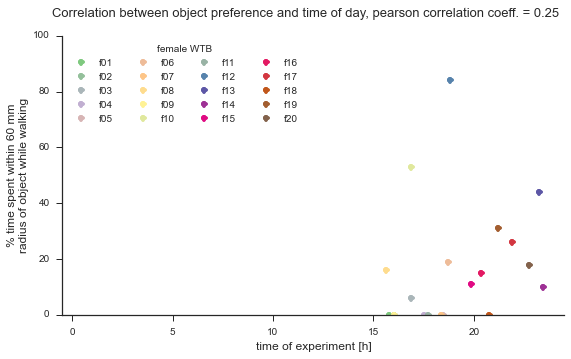

In [21]:
arenaRad = 60
objResidence = np.zeros(len(FWDataFiles))
for fly in range(len(FWDataFiles)):
    toSelect = np.logical_and(objdistall[fly]<arenaRad,vTransall[fly]>vTransTH)
    objResidence[fly] = 100*sum(toSelect)/len(objdistall[fly])

objPref = plt.figure(figsize=(9,5))
objspt = objPref.add_subplot(111)
for fly in range(len(FWDataFiles)):
    objspt.plot(exptime[fly]/(60*60),objResidence[fly],'o',color = flyCMap.to_rgba(fly))
    #(exptime/(60*60) + 12)%24
objspt.set_xlim(-0.5, 24.5)
objspt.set_ylim(0,100)
myAxisTheme(objspt)
objspt.set_xlabel('time of experiment [h]', fontsize=12)
objspt.set_ylabel('% time spent within ' + str(arenaRad) + ' mm \nradius of object while walking', fontsize=12)
objspt.legend([flyIDs[fly] for fly in range(len(FWDataFiles))], ncol=4,loc='upper left',
              frameon=False, title= gender + ' ' + genotype, fontsize=10)
objPref.suptitle('Correlation between object preference and time of day, pearson correlation coeff. = ' 
                 + str(round(pearsonr(objResidence,(exptime/(60*60) + 12)%24)[0],2)), fontsize = 13);

print pearsonr(objResidence,(exptime/(60*60) + 12)%24)
print np.corrcoef(objResidence,(exptime/(60*60) + 12)%24)

makePlotDirectory(analysisDir + 'objectPreferenceVsTime' + sep)   
objPref.savefig(analysisDir + 'objectPreferenceVsTime' + sep + genotype + '_' + gender 
                  + '_objectPreferenceVsTime_n' + str(numFlies) + '.pdf', format='pdf')

(0.35580884364361226, 0.1236431390952937)
[[ 1.          0.35580884]
 [ 0.35580884  1.        ]]
Plot directory already exists.


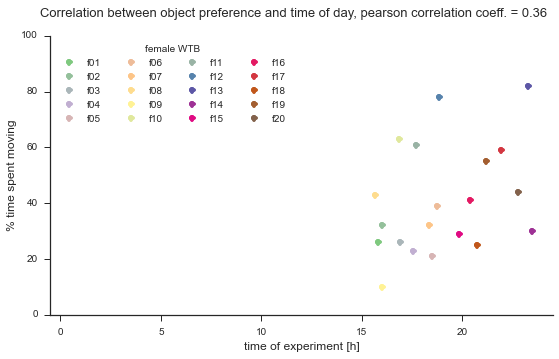

In [22]:
arenaRad = 60
percentMoving = np.asarray([100*sum(movingall[flyIDallarray==fly])/len(movingall[flyIDallarray==fly]) 
                            for fly in range(len(FWDataFiles))])

objPref = plt.figure(figsize=(9,5))
objspt = objPref.add_subplot(111)
for fly in range(len(FWDataFiles)):
    objspt.plot(exptime[fly]/(60*60),percentMoving[fly],'o',color = flyCMap.to_rgba(fly))

objspt.set_xlim(-0.5, 24.5)
objspt.set_ylim(0,100)
myAxisTheme(objspt)
objspt.set_xlabel('time of experiment [h]', fontsize=12)
objspt.set_ylabel('% time spent moving', fontsize=12)
objspt.legend([flyIDs[fly] for fly in range(len(FWDataFiles))], ncol=4,loc='upper left',
              frameon=False, title= gender + ' ' + genotype, fontsize=10)
objPref.suptitle('Correlation between object preference and time of day, pearson correlation coeff. = ' 
                 + str(round(pearsonr(percentMoving,(exptime/(60*60) + 12)%24)[0],2)), fontsize = 13);

print pearsonr(percentMoving,(exptime/(60*60) + 12)%24)
print np.corrcoef(percentMoving,(exptime/(60*60) + 12)%24)

makePlotDirectory(analysisDir + 'movingVsTime' + sep)   
objPref.savefig(analysisDir + 'movingVsTime' + sep + genotype + '_' + gender 
                  + '_movingVsTime_n' + str(numFlies) + '.pdf', format='pdf')

(0.61877499608709097, 0.0036298619552025246)
[[ 1.        0.618775]
 [ 0.618775  1.      ]]
Plot directory already exists.


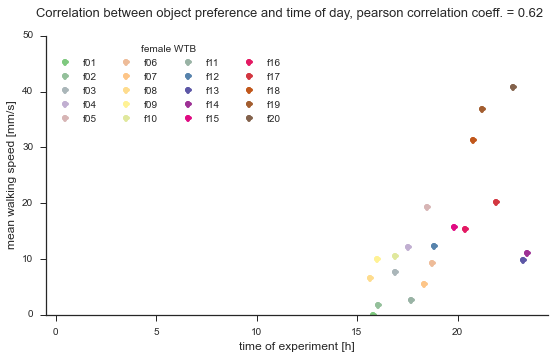

In [23]:
arenaRad = 60
meanSpeed = np.zeros(len(FWDataFiles))
for fly in range(len(FWDataFiles)):
    meanSpeed[fly] = np.median(vTransall[fly])
    
objPref = plt.figure(figsize=(9,5))
objspt = objPref.add_subplot(111)
for fly in range(len(FWDataFiles)):
    objspt.plot(exptime[fly]/(60*60),meanSpeed[fly],'o',color = flyCMap.to_rgba(fly))

objspt.set_xlim(-0.5, 24.5)
objspt.set_ylim(0,50)
myAxisTheme(objspt)
objspt.set_xlabel('time of experiment [h]', fontsize=12)
objspt.set_ylabel('mean walking speed [mm/s]', fontsize=12)
objspt.legend([flyIDs[fly] for fly in range(len(FWDataFiles))], ncol=4,loc='upper left',
              frameon=False, title= gender + ' ' + genotype, fontsize=10)
objPref.suptitle('Correlation between object preference and time of day, pearson correlation coeff. = ' 
                 + str(round(pearsonr(meanSpeed,(exptime/(60*60) + 12)%24)[0],2)), fontsize = 13);

print pearsonr(meanSpeed,(exptime/(60*60) + 12)%24)
print np.corrcoef(meanSpeed,(exptime/(60*60) + 12)%24)

makePlotDirectory(analysisDir + 'meanSpeedVsTime' + sep)   
objPref.savefig(analysisDir + 'meanSpeedVsTime' + sep + genotype + '_' + gender 
                  + '_meanSpeedVsTime_n' + str(numFlies) + '.pdf', format='pdf')

Plot directory already exists.
Plot directory already exists.
Plot directory already exists.
Plot directory already exists.
Plot directory already exists.
Plot directory already exists.
Plot directory already exists.
Plot directory already exists.
Plot directory already exists.
Plot directory already exists.
Plot directory already exists.
Plot directory already exists.
Plot directory already exists.
Plot directory already exists.
Plot directory already exists.
Plot directory already exists.
Plot directory already exists.
Plot directory already exists.
Plot directory already exists.
Plot directory already exists.


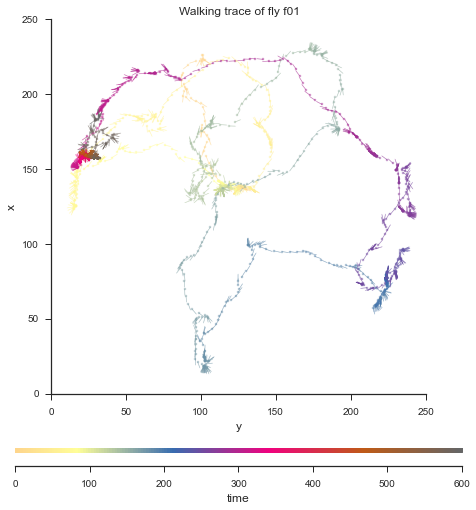

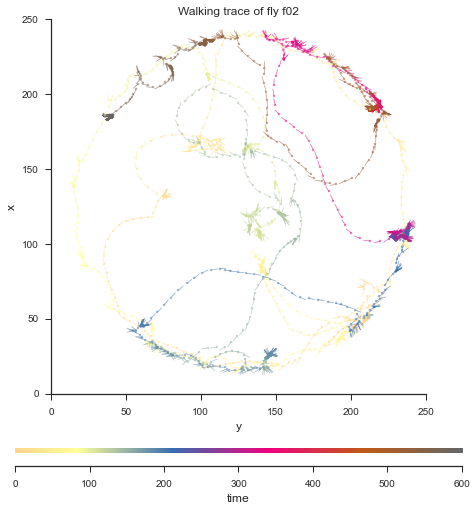

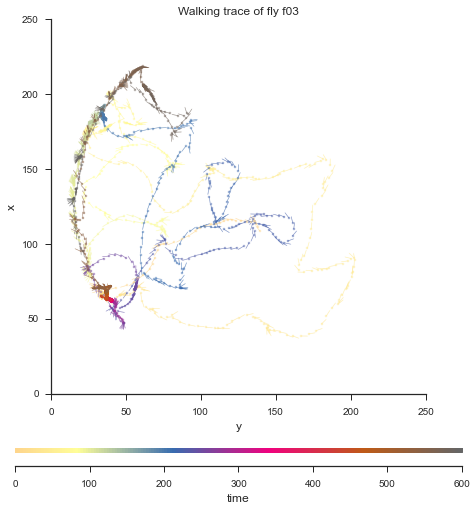

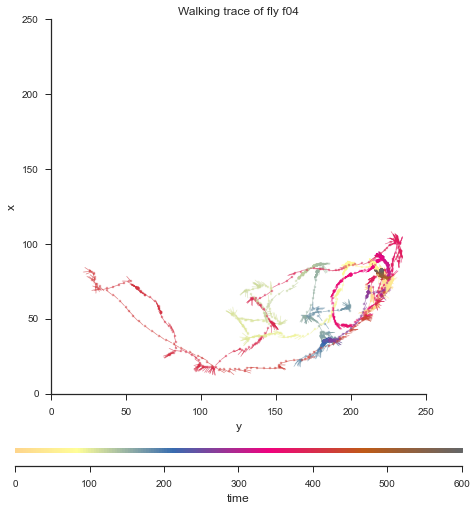

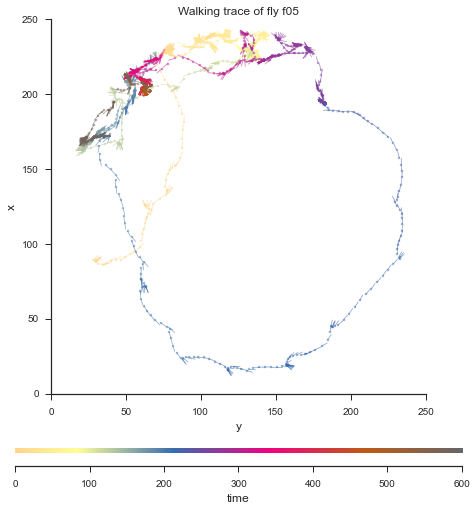

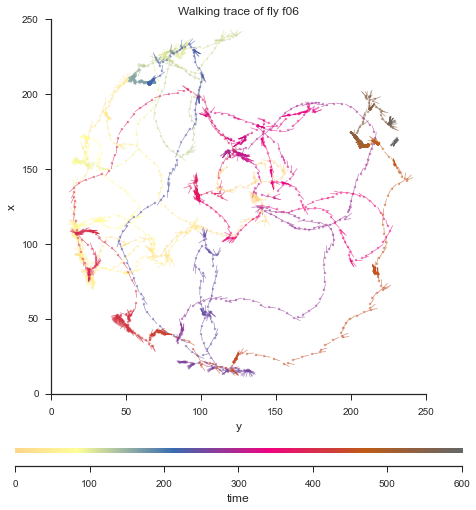

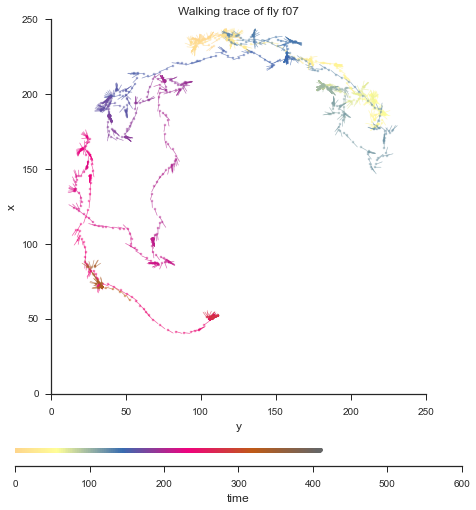

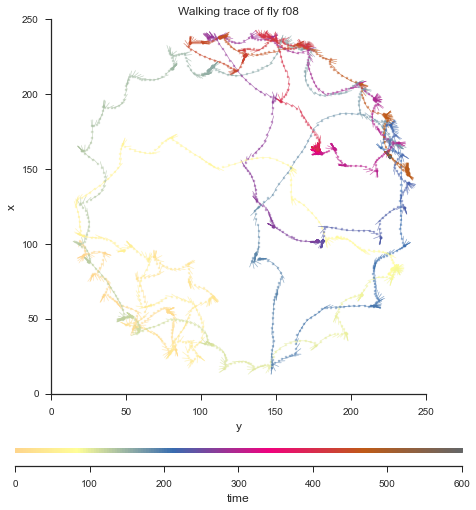

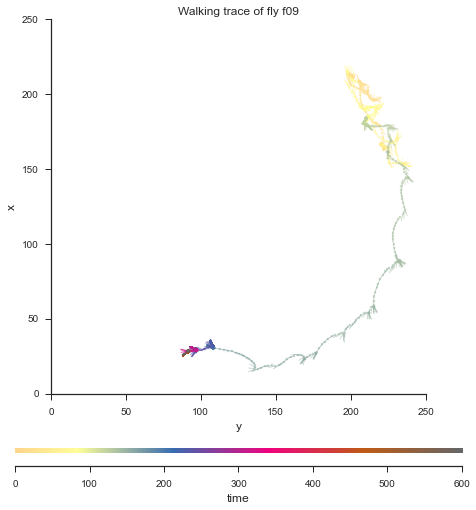

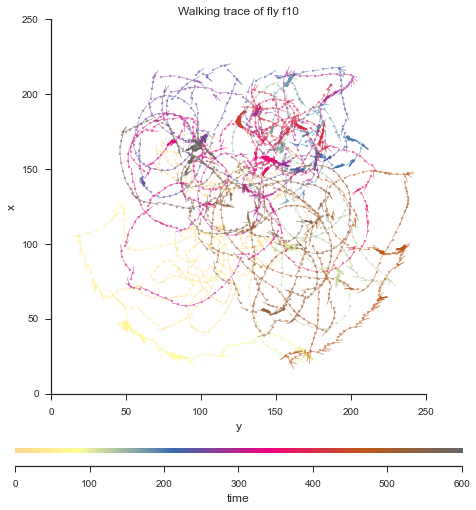

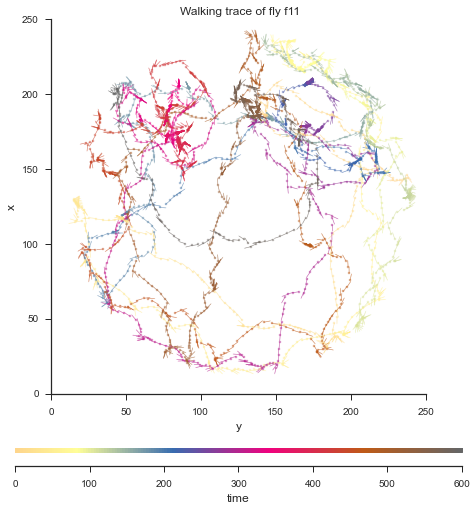

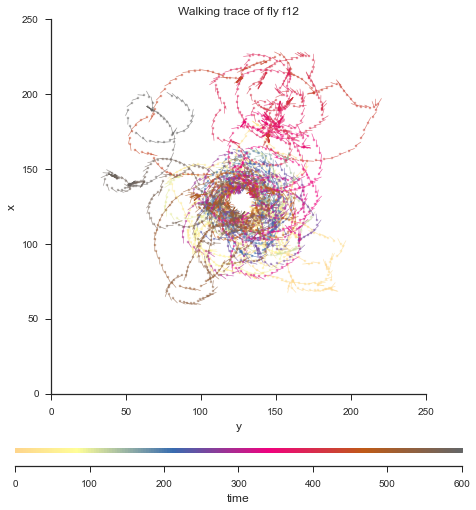

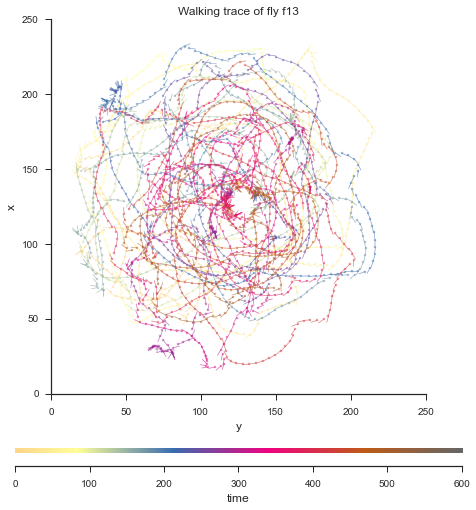

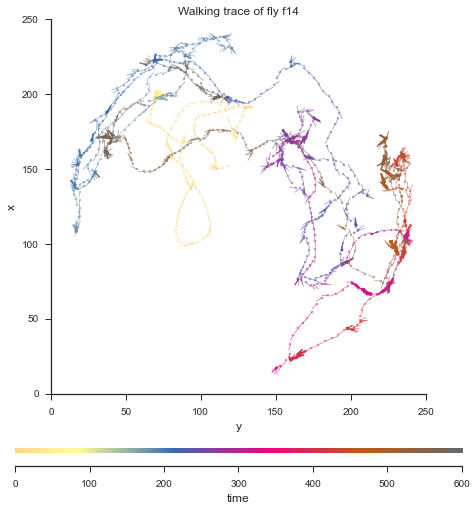

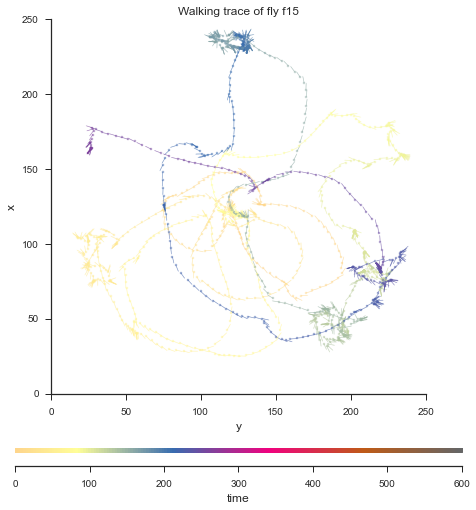

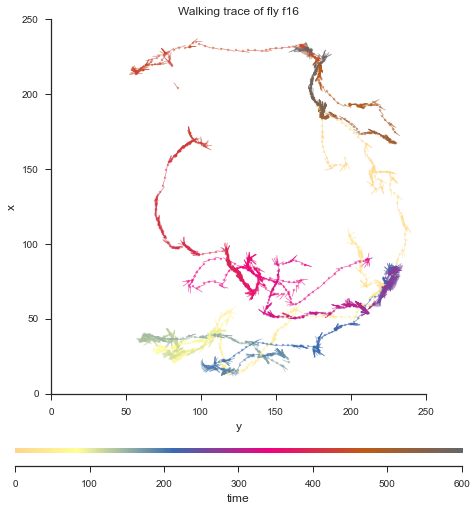

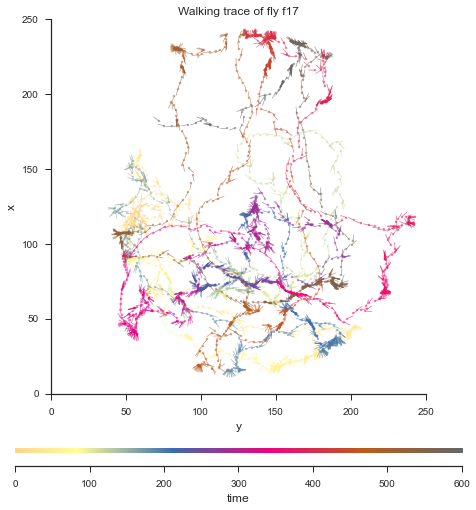

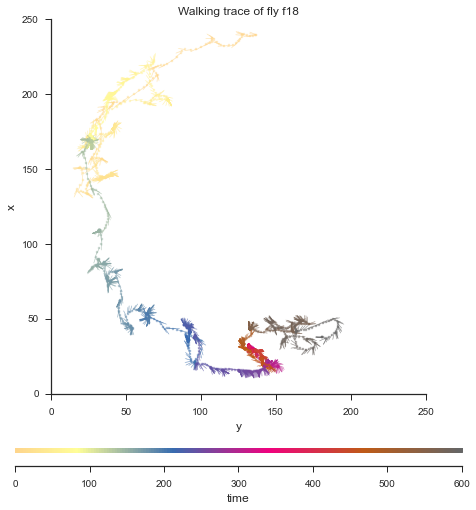

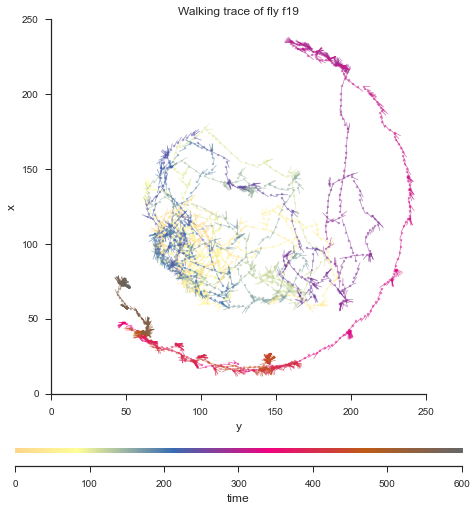

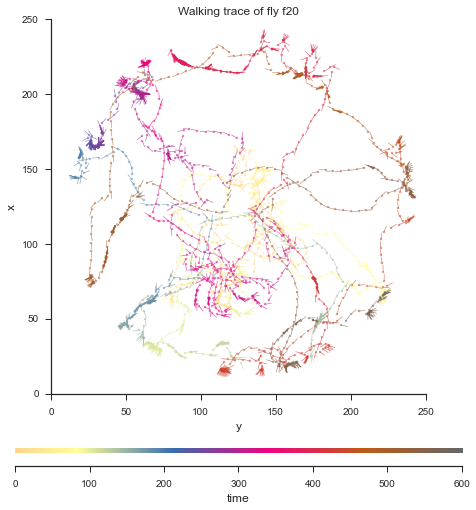

In [24]:
#Make plot of selected fly
fly=objResidence.argmax()

for fly in range(numFlies):
    frameStart = 0
    frameEnd = len(xposall[fly])
    frameStep = 2
    frameRange = range(frameStart,frameEnd,frameStep)
    colMap = 'Accent'

    trajfig = plt.figure(figsize=(8,8))
    gs = gridspec.GridSpec(2,1,height_ratios=np.hstack((12,1)))
    sns.set_style('ticks')

    axTraj = trajfig.add_subplot(gs[0]) #trace plot
    axTime = trajfig.add_subplot(gs[1]) #time line
    plotPosInRange(axTraj,axTime,frameRange,timeall[fly],xposall[fly],yposall[fly],angleall[fly],colMap,4,0.5,5)
    axTraj.set_xlim(0,250)
    axTraj.set_ylim(0,250)
    axTraj.set_ylabel('x',fontsize=12)
    axTraj.set_xlabel('y',fontsize=12)  
    axTraj.set_title('Walking trace of fly ' + flyIDs[fly])

    axTime.set_xlabel('time',fontsize=12)  
    axTime.set_xlim(0,600)
    myAxisTheme(axTraj)
    timeAxisTheme(axTime)

    makePlotDirectory(analysisDir + 'singleFlyTraces' + sep)   
    trajfig.savefig(analysisDir + 'singleFlyTraces' + sep + genotype + '_' + gender + '_' + flyIDs[fly] 
                      + '_timeColoredTrace' + '.pdf', format='pdf')


In [25]:
objDirectionall, objDistanceall, gammaFullall, gammaall, gammaVall = relationToObject(timeallarray, xposallarray, yposallarray, angleallarray, objLoc)